In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def make(path, scenario, replicas, total_gpus):
    df = pd.read_json(path, lines=True)
    df["scenario"] = scenario
    df["replicas"] = replicas
    df["num_gpus"] = total_gpus // replicas

    df["max_concurrency_scale_out"] = df["max_concurrency"] * df["replicas"]
    df_sorted = df.sort_values(by=["max_concurrency_scale_out", "median_e2el_ms"], inplace=False)
    return df_sorted

def plot(df, ymax=None):
    
    plt.figure()
    for name, group in df.groupby('scenario'):
        plt.plot(group['max_concurrency_scale_out'], group['median_e2el_ms'], marker='o', label=name)
    plt.xlabel('Max Concurrency Scale Out')
    plt.ylabel('Median E2E Latency (ms)')
    plt.title('E2E Latency vs Max Concurrency Scale Out')
    plt.legend()

    if ymax is not None:
        plt.ylim(0, ymax)
    plt.tight_layout()
    plt.show()


def plot_pareto_curve(df, title="Pareto Curve"):
    # Define colors for each scenario: Blues for pd-, Greens for no-pd-
    pd_scenarios = sorted({s for s in df['scenario'] if s.startswith('pd-')})
    no_pd_scenarios = sorted({s for s in df['scenario'] if not s.startswith('pd-')})

    pd_colors = plt.cm.Greens(np.linspace(0.2, 1.0, len(pd_scenarios)))
    no_pd_colors = plt.cm.Reds(np.linspace(0.2, 1.0, len(no_pd_scenarios)))

    color_map = {s: c for s, c in zip(pd_scenarios, pd_colors)}
    color_map.update({s: c for s, c in zip(no_pd_scenarios, no_pd_colors)})

    # Plot with lines and markers
    plt.figure(figsize=(8, 6))
    for scenario, group in df.groupby('scenario'):
        grp = group.sort_values('output_tokens_per_sec_per_user')
        plt.plot(
            grp['output_tokens_per_sec_per_user'],
            grp['output_tokens_per_sec_per_gpu'],
            marker='o',
            linestyle='-',
            label=scenario,
            color=color_map[scenario]
        )
        # Annotate concurrency on each point
        for _, row in grp.iterrows():
            plt.annotate(
                int(row['max_concurrency']),
                (row['output_tokens_per_sec_per_user'], row['output_tokens_per_sec_per_gpu']),
                textcoords="offset points", xytext=(3, 3), ha='left'
            )

    plt.xlabel('Per User Output Speed (tok/sec/usr)')
    plt.ylabel('Per GPU Throughput (tok/sec/gpu)')
    plt.title(title)
    plt.legend(title='Scenario')
    plt.tight_layout()
    plt.show()

In [63]:
!ls *.json

2ptp2-3dtp4-lb.json 4ptp2-1dtp8-lb.json tp4-old.json        tp8-old.json
4ptp2-1dep8-lb.json tp2-v2.json         tp4-v2.json         tp8-v2.json


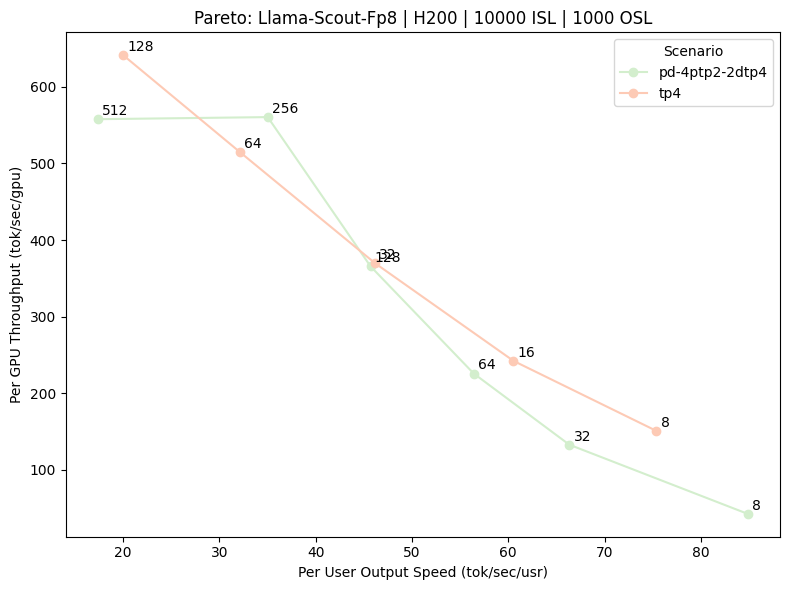

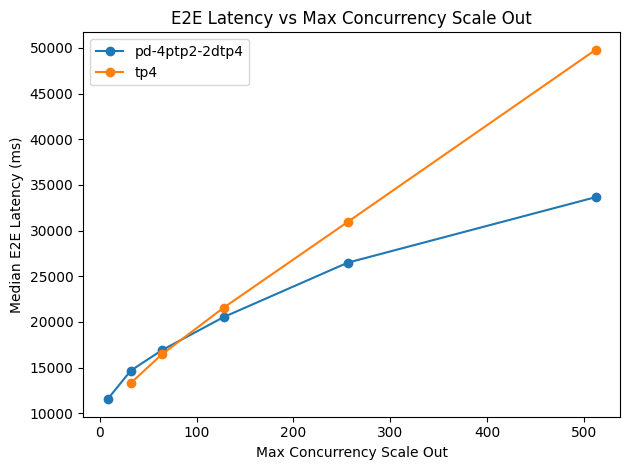

In [76]:
dfs = []

####################################
# No PD
####################################

# df_tp2 = make(
#     path="tp2-v2.json",
#     scenario="tp2",
#     replicas=8,
#     total_gpus=16
# )
# dfs.append(df_tp2)

df_tp4 = make(
    path="tp4-v2.json",
    scenario="tp4",
    replicas=4,
    total_gpus=16
)
dfs.append(df_tp4)

# df_tp8 = make(
#     path="tp8-v2.json",
#     scenario="tp8",
#     replicas=2,
#     total_gpus=16
# )
# dfs.append(df_tp8)

####################################
# PD
####################################
# df_4ptp2_1dep8_lb = make(
#     path="4ptp2-1dep8-lb.json",
#     scenario="pd-4ptp2-1dep8-lb",
#     replicas=1,
#     total_gpus=16
# )
# dfs.append(df_4ptp2_1dep8_lb)

# df_4ptp2_1dtp8_lb = make(
#     path="4ptp2-1dtp8-lb.json",
#     scenario="pd-4ptp2-1dtp8-lb",
#     replicas=1,
#     total_gpus=16
# )
# dfs.append(df_4ptp2_1dtp8_lb)

# df_2ptp2_3dtp4 = make(
#     path="2ptp2-3dtp4-lb.json",
#     scenario="pd-2ptp2-3dtp4",
#     replicas=1,
#     total_gpus=16
# )
# dfs.append(df_2ptp2_3dtp4)

df_4ptp2_2dtp4 = make(
    path="4ptp2-2dtp4-lb.json",
    scenario="pd-4ptp2-2dtp4",
    replicas=1,
    total_gpus=16
)
dfs.append(df_4ptp2_2dtp4)

####################################
# Combine
####################################
df = pd.concat(dfs, ignore_index=True)

# For pareto curve.
df["output_tokens_per_sec_per_gpu"] = df["output_throughput"] / df["num_gpus"]
df["output_tokens_per_sec_per_user"] = df["output_throughput"] / df["max_concurrency"]
plot_pareto_curve(df, title="Pareto: Llama-Scout-Fp8 | H200 | 10000 ISL | 1000 OSL")
plot(df)